In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import os
import scipy.stats as stats

In [ ]:
# 1. Setup and Data Loading 
DATA_FILE = '/root/autodl-tmp/Gold.csv' 

SEQUENCE_LENGTH = 252 

BATCH_SIZE = 64
LR = 0.0001
EPOCHS = 5000 

# WGAN-GP specific parameters
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

# Model architecture parameters
NOISE_DIM = 100
HIDDEN_DIM = 128
NUM_SAMPLES_TO_GENERATE = 1000

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Check and load data
if not os.path.exists(DATA_FILE):
    print(f"Error: data file '{DATA_FILE}' not found!")
    raise SystemExit

print(f"Loading AU9999 data from: {DATA_FILE}")
raw = pd.read_csv(DATA_FILE)

raw['Date'] = pd.to_datetime(raw['TrdDt'])
raw = raw.sort_values('Date')

data = raw[['Date', 'ClPr']].copy()
data = data.set_index('Date')
data = data.rename(columns={'ClPr': 'Close'})

data = data.loc['2020-09-30':'2025-09-30']
print(f"Kept only the first 5 years of data (2014-2018); {len(data)} days remain for quick testing.")

Loading AU9999 data from: /root/autodl-tmp/Gold.csv
Kept only the first 5 years of data (2014-2018); 1213 days remain for quick testing.


In [5]:
# 2. Data preprocessing
log_returns = np.log(data['Close'] / data['Close'].shift(1)).dropna().values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(log_returns)
sequences = []
for i in range(len(data_normalized) - SEQUENCE_LENGTH):
    sequences.append(data_normalized[i:i+SEQUENCE_LENGTH])

sequences = np.array(sequences)
print(f"Data loaded, created {len(sequences)} training samples.")
real_sequences = torch.FloatTensor(sequences).to(device)
dataset = TensorDataset(real_sequences)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print("Dataloader for AU9999 gold returns is ready.")

Data loaded, created 936 training samples.
Dataloader for AU9999 gold returns is ready.


In [6]:
# 3. Build the model 
# 3.1 LSTM Generator
class LSTMGenerator(nn.Module):
    def __init__(self, noise_dim, hidden_dim, output_dim=1):
        super(LSTMGenerator, self).__init__()
        self.lstm = nn.LSTM(input_size=noise_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.linear(lstm_out)
        return torch.tanh(out) # Use Tanh to match MinMaxScaler

# 3.2 LSTM Discriminator 
class LSTMCritic(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128):
        super(LSTMCritic, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.linear(hidden.squeeze(0))
        return out

In [7]:
# 4: Implement gradient penalty function 
def compute_gradient_penalty(critic, real_samples, fake_samples):
    alpha = torch.randn(real_samples.size(0), 1, 1, device=device).expand_as(real_samples)
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    with torch.backends.cudnn.flags(enabled=False):
        interpolated_scores = critic(interpolated)
    
    gradients = torch.autograd.grad(
        outputs=interpolated_scores,
        inputs=interpolated,
        grad_outputs=torch.ones_like(interpolated_scores),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    return gradient_penalty

In [8]:
# 5. Model training
generator = LSTMGenerator(noise_dim=NOISE_DIM, hidden_dim=HIDDEN_DIM).to(device)
critic = LSTMCritic(hidden_dim=HIDDEN_DIM).to(device)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.0, 0.9))
optimizer_c = torch.optim.Adam(critic.parameters(), lr=LR, betas=(0.0, 0.9))

print("\nStart WGAN-GP training (LSTM architecture, 5 years of data)...")
for epoch in range(EPOCHS):
    for i, (real_seqs,) in enumerate(dataloader):
        current_batch_size = real_seqs.size(0)
        for _ in range(CRITIC_ITERATIONS):
            optimizer_c.zero_grad()
            noise = torch.randn(current_batch_size, SEQUENCE_LENGTH, NOISE_DIM, device=device)
            fake_seqs = generator(noise).detach()
            real_scores = critic(real_seqs)
            fake_scores = critic(fake_seqs)
            gradient_penalty = compute_gradient_penalty(critic, real_seqs, fake_seqs)
            c_loss = fake_scores.mean() - real_scores.mean() + LAMBDA_GP * gradient_penalty
            c_loss.backward()
            optimizer_c.step()
        
        # Train Generator 
        optimizer_g.zero_grad()
        noise = torch.randn(current_batch_size, SEQUENCE_LENGTH, NOISE_DIM, device=device)
        fake_seqs = generator(noise)
        fake_scores = critic(fake_seqs)
        g_loss = -fake_scores.mean()
        g_loss.backward()
        optimizer_g.step()

    if (epoch + 1) % 500 == 0: 
        print(f"[Epoch {epoch+1}/{EPOCHS}] [Critic loss: {c_loss.item():.4f}] [Generator loss: {g_loss.item():.4f}]")
print("Training finished.\n")


Start WGAN-GP training (LSTM architecture, 5 years of data)...


/root/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[Epoch 500/5000] [Critic loss: -0.0322] [Generator loss: -3.1833]
[Epoch 1000/5000] [Critic loss: -0.1073] [Generator loss: -0.3373]
[Epoch 1500/5000] [Critic loss: -0.5831] [Generator loss: 1.4925]
[Epoch 2000/5000] [Critic loss: -1.1486] [Generator loss: 1.5348]
[Epoch 2500/5000] [Critic loss: -1.1774] [Generator loss: 1.8368]
[Epoch 3000/5000] [Critic loss: -0.9651] [Generator loss: 1.7777]
[Epoch 3500/5000] [Critic loss: -1.3653] [Generator loss: 2.3015]
[Epoch 4000/5000] [Critic loss: -1.4457] [Generator loss: 2.8166]
[Epoch 4500/5000] [Critic loss: -1.4409] [Generator loss: 3.2581]
[Epoch 5000/5000] [Critic loss: -1.7712] [Generator loss: 3.0263]
Training finished.



In [9]:
# 6. Evaluation and visualization of results
print("Generating samples and running evaluation...")
generator.eval()
with torch.no_grad():
    noise = torch.randn(NUM_SAMPLES_TO_GENERATE, SEQUENCE_LENGTH, NOISE_DIM, device=device)
    generated_normalized = generator(noise).cpu().numpy()

generated_returns = scaler.inverse_transform(generated_normalized.reshape(-1, SEQUENCE_LENGTH))
real_returns_flat = scaler.inverse_transform(real_sequences.cpu().numpy().reshape(-1, SEQUENCE_LENGTH)).flatten()
generated_returns_flat = generated_returns.flatten()

plt.style.use('seaborn-v0_8-whitegrid')

Generating samples and running evaluation...


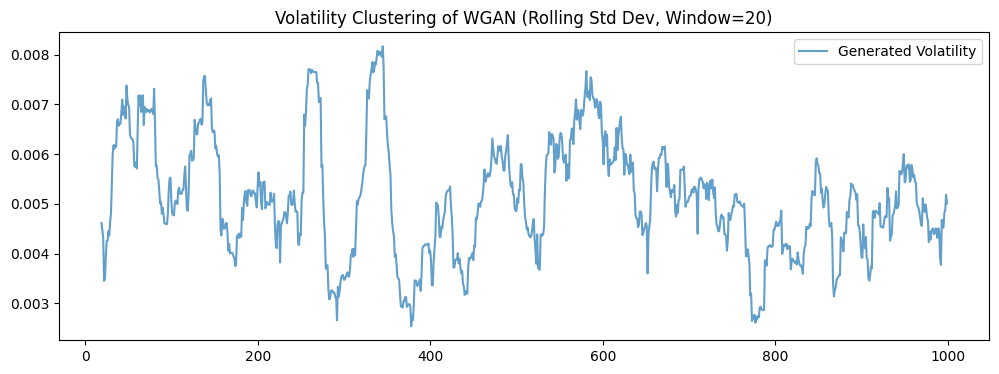

In [66]:
# Volatility Clustering
volatility_fake = pd.Series(generated_returns_flat).rolling(window=20).std()

plt.figure(figsize=(12, 4))
plt.plot(volatility_fake[:1000], label='Generated Volatility', alpha=0.7)
plt.title('Volatility Clustering of WGAN (Rolling Std Dev, Window=20)')
plt.legend()
plt.show()

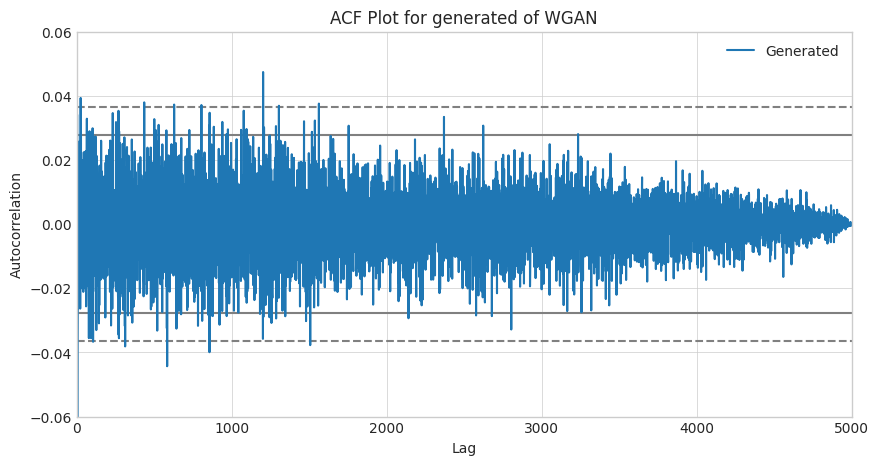

In [11]:
# ACF
plt.figure(figsize=(10, 5))

pd.plotting.autocorrelation_plot(generated_returns_flat[:5000], label='Generated')
plt.title('ACF Plot for generated of WGAN') 
plt.xlim([0, 5000])
plt.ylim([-0.06, 0.06]) 
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
plt.show()

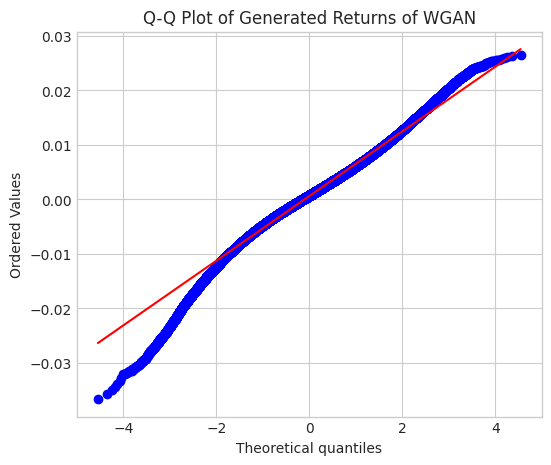

In [12]:
# Q-Q Plot
plt.figure(figsize=(6, 5))
stats.probplot(generated_returns_flat, dist="norm", plot=plt)
plt.title('Q-Q Plot of Generated Returns of WGAN')
plt.show()

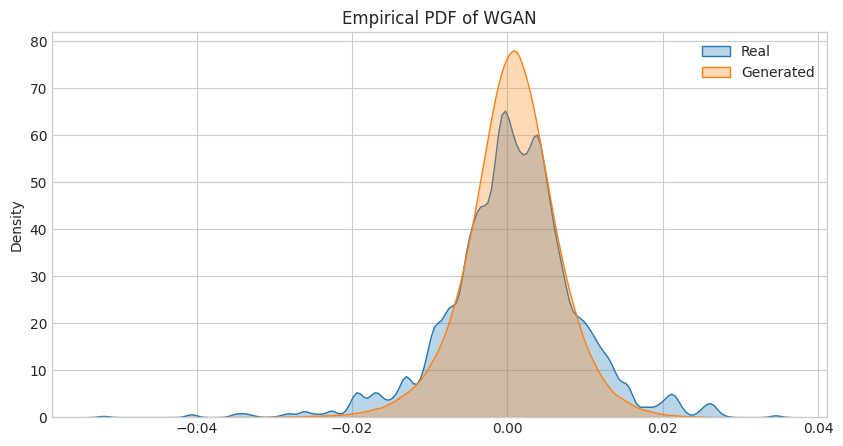

In [13]:
# KDE 
plt.figure(figsize=(10, 5))
sns.kdeplot(real_returns_flat, label='Real', fill=True, alpha=0.3)
sns.kdeplot(generated_returns_flat, label='Generated', fill=True, alpha=0.3)
plt.title('Empirical PDF of WGAN')
plt.legend()
plt.show()

In [65]:
# pd.set_option('display.float_format', lambda x: '%.6f' % x)
# wgan_stats = pd.Series(generated_returns_flat, name="WGAN").describe()
# display(wgan_stats.to_frame())
pd.set_option('display.float_format', lambda x: '%.6f' % x)
real_stats = pd.Series(real_returns_flat, name="Real").describe()
wgan_stats = pd.Series(generated_returns_flat, name="WGAN").describe()
comparison_table = pd.concat([real_stats, wgan_stats], axis=1)
display(comparison_table)

,Real,WGAN
count,235872.000000,252000.000000
mean,0.000627,0.000614
std,0.008319,0.005968
min,-0.051964,-0.036641
25%,-0.003741,-0.002826
50%,0.000770,0.000727
75%,0.005159,0.004242
max,0.034514,0.026534


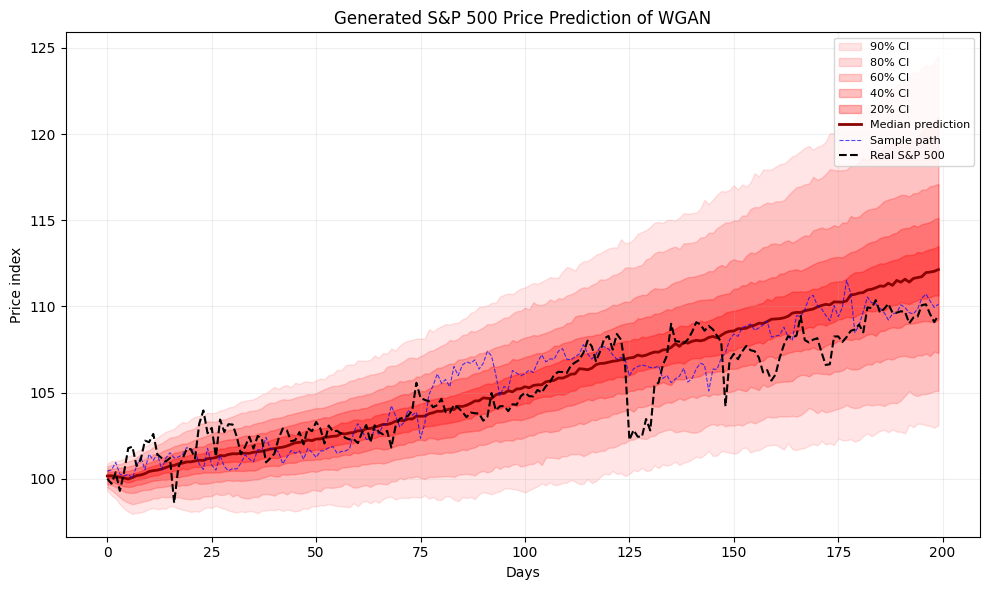

In [45]:
def returns_to_index_batch(returns, S0=100.0):
    returns = np.asarray(returns)
    if returns.ndim == 1:
        cum_ret = np.cumsum(returns)
        return S0 * np.exp(cum_ret)
    elif returns.ndim == 2:
        cum_ret = np.cumsum(returns, axis=1)
        return S0 * np.exp(cum_ret)


S0 = 100.0
T = SEQUENCE_LENGTH
N_SIM = NUM_SAMPLES_TO_GENERATE 

generator.eval()
with torch.no_grad():
    noise = torch.randn(N_SIM, T, NOISE_DIM, device=device)
    gen_norm = generator(noise).cpu().numpy()  

if gen_norm.ndim == 3:
    gen_norm = gen_norm.squeeze(-1) 

gen_norm_flat = gen_norm.reshape(-1, 1) 
gen_ret_flat = scaler.inverse_transform(gen_norm_flat)
gen_returns = gen_ret_flat.reshape(N_SIM, T) 
sim_prices = returns_to_index_batch(gen_returns, S0=S0)


close_all = data['Close'].dropna().values 
start_idx = 600   
end_idx = 800  
end_idx = min(end_idx, len(close_all))

real_close_seg = close_all[start_idx:end_idx] 
T_seg = len(real_close_seg)    

real_price = real_close_seg / real_close_seg[0] * S0 

sim_prices_seg = sim_prices[:, :T_seg] 
hist_index = close_all / close_all[0] * S0

percentiles = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95]
fan_data = np.percentile(sim_prices_seg, percentiles, axis=0) 

p5, p10, p20, p30, p40, p50, p60, p70, p80, p90, p95 = fan_data
x = np.arange(T_seg)

plt.style.use("default")

fig, ax2 = plt.subplots(figsize=(10, 6))

ax2.fill_between(x, p5,  p95, alpha=0.10, color="red", label="90% CI")
ax2.fill_between(x, p10, p90, alpha=0.15, color="red", label="80% CI")
ax2.fill_between(x, p20, p80, alpha=0.20, color="red", label="60% CI")
ax2.fill_between(x, p30, p70, alpha=0.25, color="red", label="40% CI")
ax2.fill_between(x, p40, p60, alpha=0.30, color="red", label="20% CI")
ax2.plot(x, p50, color="darkred", linewidth=2.0, label="Median prediction")

n_sample_paths = 1
n_sim = sim_prices_seg.shape[0]
indices = np.linspace(0, n_sim - 1, n_sample_paths, dtype=int)

for i, idx in enumerate(indices):
    sample_path = sim_prices_seg[idx]
    ax2.plot(
        x, sample_path,
        linewidth=0.8,
        linestyle="--",
        alpha=0.7,
        color="blue",
        label="Sample path" if i == 0 else None
    )

ax2.plot(
    x, real_price,
    linestyle="--",
    linewidth=1.5,
    color="black",
    label="Real S&P 500"
)

ax2.set_xlabel("Days")
ax2.set_ylabel("Price index")
ax2.set_title("Generated S&P 500 Price Prediction of WGAN")
ax2.grid(alpha=0.2)

handles, labels = ax2.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax2.legend(unique.values(), unique.keys(), loc="upper right", fontsize=8)

plt.tight_layout()
plt.show()

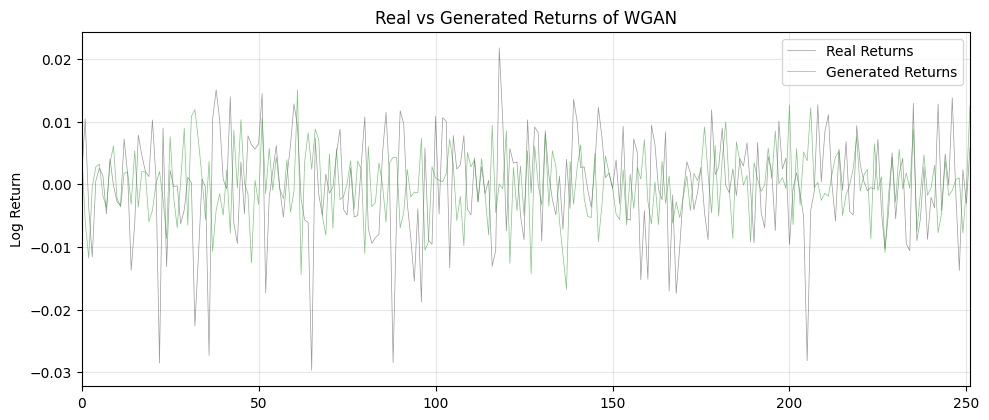

In [64]:
S0 = 100.0
target_len = 1000

close_all = data['Close'].dropna().values  
window_start = 0
window_end = 1000

seg_close = close_all[window_start:window_end]  
real_len = len(seg_close)

real_ret_full = np.diff(np.log(seg_close))   

fan_seg = fan_data[:, :target_len] 
median_path = fan_seg[5]

ret_len = min(len(real_ret_full), sim_returns.shape[1])
real_ret_full = np.diff(np.log(seg_close))[:ret_len]
sample_ret = sim_returns[0, :ret_len]

plt.figure(figsize=(10, 8))

# ----- Return Plot -----
plt.subplot(2, 1, 2)

plt.plot(x_ret, real_ret,
         label='Real Returns',
         color='black', alpha=0.4, linewidth=0.5)

plt.plot(x_ret, sample_ret,
         label='Generated Returns',
         color='#2ca02c', alpha=0.6, linewidth=0.5)

plt.title("Real vs Generated Returns of WGAN", fontsize=12)
plt.ylabel("Log Return")
plt.xlim([0, ret_len - 1])
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()